# Generating overlayed clips from existing clips from LibriCSS
Intuition: by using the mappings within spectrogram_labels its possible to overlay clips and sum their respective speaker counts. For example, overlaying a clip of 2 labelled speakers onto a clip with 1 labelled speaker creates a clip with 3 labelled speakers. A new spectrogram of this clip can be made, allowing a CNN to learn representations of more speakers than there are available in the data set.

In [1]:
import os
import numpy as np
import pandas as pd
import math
import ast
from time import time
import soundfile as sf
import re
from pathlib import Path
import librosa
import torch

from src.utils.SpectrogramExtractor import SpectrogramExtractor

labels = pd.read_csv(r'data\spectrogram_labels.csv')
labels['speakers'] = labels['speakers'].apply(ast.literal_eval) # str to list ( "[]" --> [] )
labels.tail(10)

,spectrogram,speaker_count,speakers
36077,OV40_session9_clip90.pt,2,"[2961, 1995]"
36078,OV40_session9_clip91.pt,1,[2961]
36079,OV40_session9_clip92.pt,1,[2961]
36080,OV40_session9_clip93.pt,1,[2961]
36081,OV40_session9_clip94.pt,1,[2961]
36082,OV40_session9_clip95.pt,1,[2961]
36083,OV40_session9_clip96.pt,1,[2961]
36084,OV40_session9_clip97.pt,2,"[2961, 7176]"
36085,OV40_session9_clip98.pt,2,"[2961, 7176]"
36086,OV40_session9_clip99.pt,2,"[2961, 7176]"


## Setup
These helpers do the heavy lifting. They're largely dependent on the format of `spectrogram_labels.csv`, which is setup in `0-2_Speaker_Data.ipynb`

In [24]:
def data_overlay(num_attempts, output_folder = r'data/clips_aug', sr = 16000, verbose=True, export=True):


    # Check output folder is empty, prevents re-runs & data bloat.
    assert not any(Path(output_folder).glob("*.wav")), f"{output_folder} must be empty before running."


    # init
    start = time()
    extended_labels = []
    seen_pairs = set()


    # main loop
    for _ in range(num_attempts):


        # if enabled, give progress updates
        if verbose and _ % 1000 == 0:
            elapsed = time() - start
            print(f'Attempt {_} of {num_attempts} | Elapsed: {elapsed:.1f}s')


        # Randomly select two different rows
        base_row = labels.sample(n=1).iloc[0]
        overlay_row = labels.sample(n=1).iloc[0]


        # Avoid overlaying the same speaker twice (unrealistic that one person can say two things at once!)
        if (set(base_row['speakers']) & set(overlay_row['speakers'])): continue


        # set mapping
        base_clip = base_row.iloc[0]
        base_count = base_row.iloc[1]
        base_speakers = base_row.iloc[2]
        overlay_clip = overlay_row.iloc[0]
        overlay_count = overlay_row.iloc[1]
        overlay_speakers = overlay_row.iloc[2]


        # Avoid overlaying the same clips twice
        pair_key = tuple(sorted((base_clip, overlay_clip)))     # (we use `sorted` so that [A,B] == [B,A])
        if pair_key in seen_pairs: continue
        seen_pairs.add(pair_key)


        # Load and align audio from mapping
        base_path = base_row.iloc[0].replace('.pt', '.wav')
        overlay_path = overlay_row.iloc[0].replace('.pt', '.wav')
        base_audio, _ = librosa.load(r'data/clips/' + base_path, sr=sr)
        overlay_audio, _ = librosa.load(r'data/clips/' + overlay_path, sr=sr)


        # Pad output to the longer audio length
        max_len = max(len(base_audio), len(overlay_audio))
        base_audio = np.pad(base_audio, (0, max_len - len(base_audio)))
        overlay_audio = np.pad(overlay_audio, (0, max_len - len(overlay_audio)))


        # Overlay by summing
        mixed_audio = base_audio + overlay_audio
        mixed_audio = mixed_audio / np.max(np.abs(mixed_audio))  # Normalize


        # Save new clip, if enabled
        mixed_clip_name = f"{os.path.splitext(base_clip)[0]}_overlay_{os.path.splitext(overlay_clip)[0]}.wav"
        if export: sf.write(f"{output_folder}/{mixed_clip_name}", mixed_audio, sr)


        # Log new label
        extended_labels.append([mixed_clip_name, base_count + overlay_count, base_speakers + overlay_speakers])


    # Convert new labels to DataFrame
    df = pd.DataFrame(extended_labels, columns=['spectrogram', 'speaker_count', 'speakers'])

    # save labels, if enabled
    if export: df.to_csv('data/spectrogram_labels_aug', index=False)
    
    print(f"data_overlay() complete. Created {len(extended_labels)} new clips.")
    return df



# As before, turn each clip into spectrogram
def clips_to_specs(in_path=r"data/clips_aug", out_path=r"data/spectrograms_aug"):

    extractor = SpectrogramExtractor()


    clips_dir = Path(in_path)
    specs_dir = Path(out_path)
    specs_dir.mkdir(parents=True, exist_ok=True)


    # Convert all clips to spectrograms
    for wav_path in clips_dir.glob("*.wav"):

        spec = extractor(str(wav_path))   # Returns a tensor shape: [1, n_mels, time_frames]
        spec = spec.squeeze(0)  # Remove the leading channel dim. Now [n_mels, time_frames]
        

        out_path = specs_dir / wav_path.with_suffix(".pt").name
        torch.save(spec, out_path) # save as a PyTorch tensor

## Running the wrappers

In [25]:
# Create augmented data at a 1:1 ratio with existing data. There are 36000 samples from libricss so lets create ~36000 overlays.
attempts = len(labels); print(f"Size of current training dataset: {attempts}. ")
df = data_overlay(num_attempts=attempts)
clips_to_specs()

Size of current training dataset: 36087. 
Attempt 0 of 36087 | Elapsed: 0.0s
Attempt 1000 of 36087 | Elapsed: 5.9s
Attempt 2000 of 36087 | Elapsed: 11.7s
Attempt 3000 of 36087 | Elapsed: 20.7s
Attempt 4000 of 36087 | Elapsed: 47.3s
Attempt 5000 of 36087 | Elapsed: 71.3s
Attempt 6000 of 36087 | Elapsed: 92.5s
Attempt 7000 of 36087 | Elapsed: 113.1s
Attempt 8000 of 36087 | Elapsed: 137.8s
Attempt 9000 of 36087 | Elapsed: 161.6s
Attempt 10000 of 36087 | Elapsed: 182.1s
Attempt 11000 of 36087 | Elapsed: 201.2s
Attempt 12000 of 36087 | Elapsed: 218.5s
Attempt 13000 of 36087 | Elapsed: 232.9s
Attempt 14000 of 36087 | Elapsed: 249.6s
Attempt 15000 of 36087 | Elapsed: 270.8s
Attempt 16000 of 36087 | Elapsed: 291.1s
Attempt 17000 of 36087 | Elapsed: 309.1s
Attempt 18000 of 36087 | Elapsed: 327.5s
Attempt 19000 of 36087 | Elapsed: 348.6s
Attempt 20000 of 36087 | Elapsed: 367.4s
Attempt 21000 of 36087 | Elapsed: 387.6s
Attempt 22000 of 36087 | Elapsed: 407.2s
Attempt 23000 of 36087 | Elapsed: 427

### Final DataFrame: Labelled, **layered** Spectrograms
Each clip originally contains 0-2 speakers, so we can assume the resulting data will have 0-4 speakers

In [ ]:
df.head(10)

,spectrogram,speaker_count
0,OV30_session3_clip222_overlay_OV10_session4_cl...,2
1,OV10_session3_clip594_overlay_0S_session9_clip...,3
2,OV10_session6_clip20_overlay_0S_session8_clip1...,2
3,OV40_session0_clip175_overlay_OV30_session5_cl...,3
4,OV30_session0_clip214_overlay_OV10_session5_cl...,2
5,OV40_session8_clip358_overlay_OV30_session0_cl...,3
6,OV40_session0_clip286_overlay_0S_session6_clip...,2
7,0L_session6_clip159_overlay_0S_session1_clip35...,2
8,OV40_session1_clip302_overlay_0L_session1_clip...,2
9,OV40_session6_clip208_overlay_OV40_session2_cl...,2


In [55]:
unique_values = df['speaker_count'].unique()
print(unique_values)

[2 3 1 4 0 5]


In [52]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
from IPython.display import Audio, display

def plot_spectrogram_with_audio(clip, df=df, hop_ms=10):
    # Build paths
    audio_path = f'data/clips_aug/{clip}.wav'
    spec_path = f'data/spectrograms_aug/{clip}.pt'

    # Load and play audio
    rate, waveform = wavfile.read(audio_path)
    display(Audio(waveform, rate=rate))

    # Load spectrogram
    spectrogram = torch.load(spec_path).squeeze()

    # Lookup speaker count
    row = df.loc[df['spectrogram'] == f'{clip}.wav', 'speaker_count']
    speaker_count = row.values[0] if not row.empty else 'Unknown'

    # Calculate time axis
    n_frames = spectrogram.shape[1]
    duration_sec = (n_frames * hop_ms) / 1000

    # Plot
    plt.figure(figsize=(10, 4))
    plt.imshow(spectrogram.numpy(), aspect='auto', origin='lower',
               extent=[0, duration_sec, 0, spectrogram.shape[0]],
               cmap='magma')
    plt.title(f'{clip} — Speaker Count: {speaker_count}')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency bins')
    plt.colorbar(label='Amplitude')
    plt.tight_layout()
    plt.show()

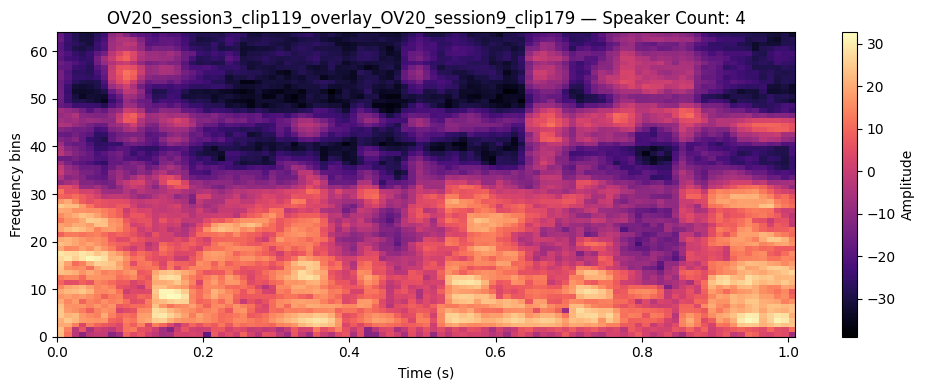

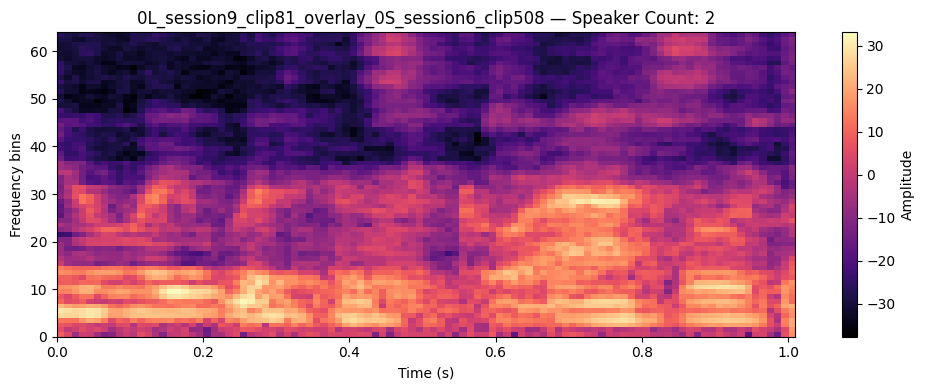

In [54]:
x1 = 'OV20_session3_clip119_overlay_OV20_session9_clip179.wav'
plot_spectrogram_with_audio(clip=x1.replace('.wav', ''))

x2 = '0L_session9_clip81_overlay_0S_session6_clip508.wav'
plot_spectrogram_with_audio(clip=x2.replace('.wav', ''))

### It's visibly harder to distinguish a visible trend as speakers increase.